# Практическое занятие 15

## Вариант 11

In [14]:
class Config:
	"""
    Класс для хранения конфигурационных параметров системы массового обслуживания.
    - LAMBDA_RATE: Интенсивность поступления заявок (звонков в час)
	- MU_RATE: Интенсивность обслуживания одним каналом (звонков в час)
	- NUM_CHANNELS: Количество каналов (операторов) в системе
	- DURATION: Время T в часах, за которое рассчитываются характеристики системы
    """

	LAMBDA_RATE = 30
	MU_RATE = 5
	NUM_CHANNELS = 3
	QUEUE_SIZE = 3
	DURATION = 0.75

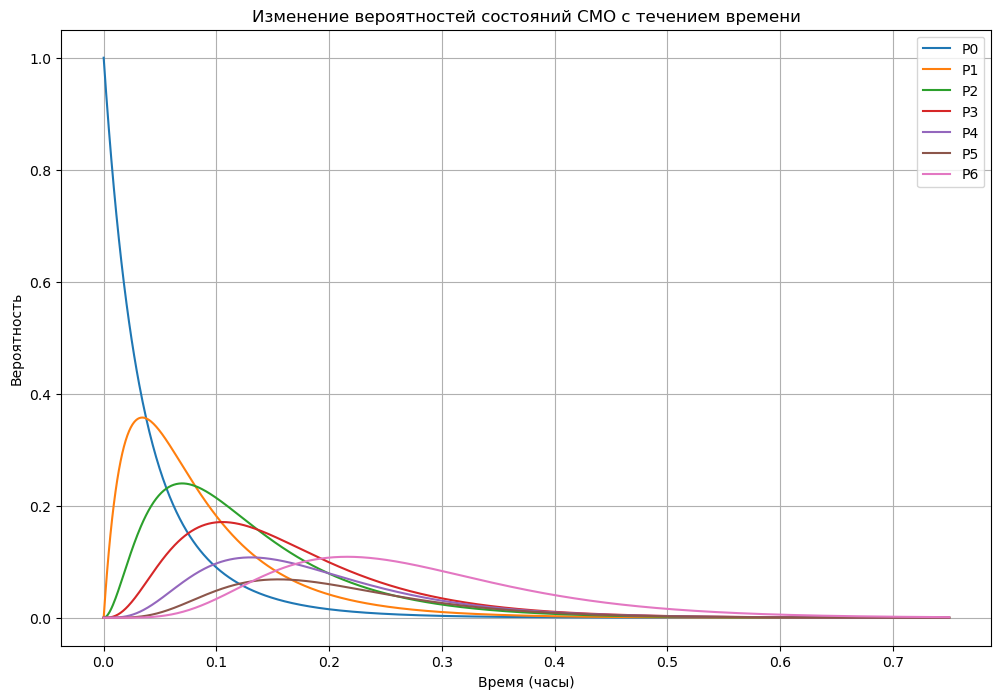

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint



class QueueingSystem:
	"""
	Класс для создания СМО
	"""
	def __init__(self, lambda_rate, mu_rate, s, n):
		"""
        Инициализация СМО
        :param lambda_rate: Интенсивность поступления донесений (заявок в час)
        :param mu_rate: Интенсивность обработки одним офицером (заявок в час)
        :param s: Количество офицеров (каналов обслуживания)
        :param n: Максимальное количество донесений в очереди
        """
		self.lambda_rate = lambda_rate
		self.mu_rate = mu_rate
		self.s = s
		self.n = n

	def dPdt(self, P, t):
		"""
		Вычисляет производные вероятностей состояний системы во времени.
		:param P: Массив вероятностей состояний системы.
		:param t: Текущее время.
		:return: Массив производных вероятностей состояний системы.
		"""
		dPdt = np.zeros(self.s + self.n + 1)
		# dP_0/dt
		dPdt[0] = self.mu_rate * P[1] - self.lambda_rate * P[0]
		# dP_i/dt для i = 1, 2
		for i in range(1, self.s):
			dPdt[i] = self.lambda_rate * P[i - 1] - (self.lambda_rate + i * self.mu_rate) * P[i] + i * self.mu_rate * P[i + 1]
		# dP_3/dt
		dPdt[self.s] = self.lambda_rate * P[self.s - 1] - (self.lambda_rate + self.s * self.mu_rate) * P[self.s] + self.s * self.mu_rate * P[self.s + 1]
		# dP_i/dt для i = 4, 5
		for i in range(self.s + 1, self.s + self.n):
			dPdt[i] = self.lambda_rate * P[i - 1] - (self.lambda_rate + self.s * self.mu_rate) * P[i]
		# dP_6/dt
		dPdt[self.s + self.n] = self.lambda_rate * P[self.s + self.n - 1] - self.s * self.mu_rate * P[self.s + self.n]
		return dPdt

	def simulate(self, time_horizon):
		"""
        Симуляция динамики системы
        :param time_horizon: Временной горизонт для моделирования (часы)
        """
		P0 = np.zeros(self.s + self.n + 1)
		P0[0] = 1  # Начальное состояние: нет донесений и занятых офицеров
		t = np.linspace(0, time_horizon, 1000)
		P = odeint(self.dPdt, P0, t)
		return t, P

	def plot_dynamics(self, t, P):
		"""
        Визуализирует динамику вероятностей состояний системы во времени.
        :param t: Временная шкала.
        :param P: Массив вероятностей состояний системы на каждый момент времени.
        """
		plt.figure(figsize=(12, 8))
		for i in range(self.s + self.n + 1):
			plt.plot(t, P[:, i], label=f'P{i}')

		plt.title('Изменение вероятностей состояний СМО с течением времени')
		plt.xlabel('Время (часы)')
		plt.ylabel('Вероятность')
		plt.legend()
		plt.grid(True)
		plt.show()

# Создаем экземпляр класса QueueingSystem
queue_sys = QueueingSystem(lambda_rate=Config.LAMBDA_RATE, mu_rate=Config.MU_RATE, s=Config.NUM_CHANNELS, n=Config.QUEUE_SIZE)

# Симуляция и построение графиков
t, P = queue_sys.simulate(time_horizon=Config.DURATION)
queue_sys.plot_dynamics(t, P)



In [30]:
class SMOCharacteristics:
	"""
	Класс для расчета основных характеристик системы массового обслуживания.
	"""
	def __init__(self, lambda_rate, mu_rate, num_channels, duration, queue_size):
		"""
        Инициализация параметров системы массового обслуживания.

        :param lambda_rate: Интенсивность поступления заявок (звонков в час).
        :param mu_rate: Интенсивность обслуживания одним каналом (звонков в час).
        :param num_channels: Количество каналов (операторов) в системе.
        :param duration: Время T в часах, за которое рассчитываются характеристики системы.
        :param queue_size: Ограничение на количество ожидающих заявок (длина очереди).
        """
		self.lambda_rate = lambda_rate
		self.mu_rate = mu_rate
		self.num_channels = num_channels
		self.duration = duration  # Время T в часах
		self.queue_size = queue_size
		self.ksi = self.calculate_ksi()
		self.P0 = self.calculate_probability_of_downtime()
		self.v = self.calculate_average_queue_length()
		self.n = self.calculate_total_system_requests()

	def calculate_ksi(self):
		"""
		Рассчитывает интенсивность нагрузки на СМО (ksi = lambda_rate / mu_rate).

		:return: Интенсивность нагрузки на систему.
		"""
		return self.lambda_rate / self.mu_rate

	def calculate_probability_of_downtime(self):
		"""
		Вычисляет вероятность простоя системы (P0).

        :return: Вероятность того, что все каналы свободны.
		"""
		sum1 = sum([(self.ksi ** i) / np.math.factorial(i) for i in range(self.num_channels)])
		sum2 = sum([(self.num_channels ** self.num_channels / np.math.factorial(self.num_channels)) *
					((self.ksi / self.num_channels) ** i) for i in range(self.num_channels, self.num_channels + self.queue_size + 1)])
		return 1 / (sum1 + sum2)

	def calculate_probabilities(self):
		"""
        Создает словарь вероятностей того, что ровно i каналов заняты.
        """
		probabilities = {}
		for i in range(self.num_channels + 1):
			probabilities[f'P{i}'] = self.P0 * (self.ksi**i) / np.math.factorial(i)
		return probabilities

	def calculate_queue_probabilities(self):
		"""
		Вычисляет вероятности для состояний, когда все s каналов заняты и очередь длины i.
		"""
		queue_probabilities = {}
		for i in range(1, self.queue_size + 1):
			queue_probabilities[f'P{self.num_channels + i}'] = self.P0 * (
					self.num_channels**self.num_channels / np.math.factorial(self.num_channels)
			) * ((self.ksi / self.num_channels) ** i)
		return queue_probabilities

	def calculate_rejection_probability(self):
		"""
		Вычисляет вероятность отказа (не попасть в очередь длины n).
		"""
		return self.P0 * (self.num_channels**self.num_channels / np.math.factorial(self.num_channels)) * ((self.ksi / self.num_channels) ** self.queue_size)

	def average_incoming_requests_during_T(self):
		"""
		Рассчитывает среднее число заявок, поступающих в систему за время T.

        :return: Среднее количество заявок за время T.
		"""
		return self.lambda_rate * self.duration

	def average_service_time_per_request(self):
		"""
		Вычисляет среднее время обслуживания одной заявки.

        :return: Среднее время обслуживания одной заявки.
		"""
		return 1 / self.mu_rate

	def average_service_time_per_channel_for_T(self):
		"""
		Вычисляет среднее время обслуживания одним каналом заявок, поступивших за время T.

        :return: Среднее время обслуживания заявок за время T одним каналом.
        """
		return self.ksi * self.duration

	def average_number_of_busy_channels(self):
		"""
        Вычисляет среднее число занятых каналов в системе.
        """
		channel_probabilities = self.calculate_probabilities()
		queue_probabilities = self.calculate_queue_probabilities()
		average_busy = sum([i * channel_probabilities.get(f'P{i}', 0) for i in range(1, self.num_channels + 1)])
		average_busy += sum([self.num_channels * queue_probabilities.get(f'P{self.num_channels+i}', 0) for i in range(1, self.queue_size + 1)])
		return average_busy

	def calculate_average_queue_length(self):
		"""
        Вычисляет среднее число заявок в очереди.
        """
		numerator = (self.ksi ** (self.num_channels + 1))
		denominator = np.math.factorial(self.num_channels - 1) * (self.num_channels - self.ksi)**2
		return (numerator / denominator) * self.P0

	def calculate_average_system_time(self):
		"""
		Вычисляет среднее время пребывания заявки в системе.
		"""
		total_requests = self.calculate_total_system_requests()
		return total_requests / self.lambda_rate

	def calculate_average_queue_time(self):
		"""
		Вычисляет среднее время пребывания заявки в очереди.
		"""
		return self.v / self.lambda_rate

	def calculate_total_system_requests(self):
		"""
        Вычисляет общее число заявок в системе.
        """
		return self.ksi + self.v


# Использование класса
smo = SMOCharacteristics(
	lambda_rate=Config.LAMBDA_RATE,
	mu_rate=Config.MU_RATE,
	num_channels=Config.NUM_CHANNELS,
	duration=Config.DURATION,
	queue_size=Config.QUEUE_SIZE)

# Получение характеристик
print(f'кси: {smo.ksi}')
print(f'Вероятность простоя: {smo.calculate_probability_of_downtime()}')
print(f'Вероятности, что ровно i каналов заняты (без очереди): {smo.calculate_probabilities()}')
print(f'Вероятности, что все s каналов заняты и очередь длины i: {smo.calculate_queue_probabilities()}')
print(f'Вероятность отказа (не попасть в очередь длины n): {smo.calculate_rejection_probability()}')
print(f'Среднее число заявок в системе за время T: {smo.average_incoming_requests_during_T()} в час')
print(f'Среднее время обслуживания 1 заявки: {smo.average_service_time_per_request()}')
print(f'Среднее время обслуживания одним каналом заявок, поступивших за время T: {smo.average_service_time_per_channel_for_T()}')
print(f'Среднее число занятых каналов: {smo.average_number_of_busy_channels()}')
print(f'Среднее число заявок в очереди: {smo.calculate_average_queue_length()}')
print(f'Среднее время пребывания заявки в очереди: {smo.calculate_average_queue_time()}')
print(f'Общее число заявок в системе: {smo.calculate_total_system_requests()}')
print(f'Среднее время ожидания заявки: {smo.calculate_average_queue_time()}')
print(f'Вычисляет среднее время пребывания заявки в системе: {smo.calculate_average_system_time()}')

кси: 6.0
Вероятность простоя: 0.0017699115044247787
Вероятности, что ровно i каналов заняты (без очереди): {'P0': 0.0017699115044247787, 'P1': 0.010619469026548672, 'P2': 0.03185840707964602, 'P3': 0.06371681415929203}
Вероятности, что все s каналов заняты и очередь длины i: {'P4': 0.01592920353982301, 'P5': 0.03185840707964602, 'P6': 0.06371681415929203}
Вероятность отказа (не попасть в очередь длины n): 0.06371681415929203
Среднее число заявок в системе за время T: 22.5 в час
Среднее время обслуживания 1 заявки: 0.2
Среднее время обслуживания одним каналом заявок, поступивших за время T: 4.5
Среднее число занятых каналов: 0.6
Среднее число заявок в очереди: 0.12743362831858407
Среднее время пребывания заявки в очереди: 0.004247787610619469
Общее число заявок в системе: 6.127433628318584
Среднее время ожидания заявки: 0.004247787610619469
Вычисляет среднее время пребывания заявки в системе: 0.20424778761061946
